### OUTTA AI 부트캠프 딥러닝반 7차 실습 : Single Shot Object Detection (YOLO)


<h4><div style="text-align: right"> Last Edit: July 09, 2023. </div> <br>


## 우선, 다음의 코드를 실행하여 실습에 사용할 데이터셋을 다운받도록 하자.

In [ ]:
!gdown --id 10o0Af1f5B3vEgTQW4N9_ZRDgYNwNLdfz
!gdown --id 1HPntQj0FKOLNbQT2M-Hb6Ux7k6lvW6C4
!unzip "/content/OD_dataset.zip"
!unzip "/content/OD_utill.zip"

## 이후, 다음의 셀을 시행하여 이번 실습에 필요한 라이브러리를 import 하자.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.datasets as dsets

import numpy as np
import cv2

import os
import struct
import copy
import random
import function
import time
import datetime

import math
from util import *
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils import data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Object Detection?

>
> <img src="https://drive.google.com/uc?export=view&id=1RuugQ9UayctyiBexEDtCGxqTrorZDMKF" alt="no_image" style="width: 800px;"/>
>
> - 위 사진을 통해 classification과 detection의 차이를 볼 수 있습니다.
>
> - Image classification에서, 전체 image는 single label로 분류됩니다.
>
> - 그러나 object detection에서는, 하나의 이미지 안에서 Object를 구체적으로 Localize합니다. 이 때 Object는 여러 개가 될 수 있습니다.
>
> - 이미지가 주어지면, Object Detection Network는 총 4개의 output을 출력합니다
: bounding box, class label, probability score ,confidence score
>

### 2. YOLO

>
> <img src="https://drive.google.com/uc?export=view&id=1YGXOBXHFk4PlbII3Rp1b97-P7tkaPAAa" alt="no_image" style="width: 800px;"/>
>
> - YOLO는 object detection의 알고리즘 중 하나입니다.
>
> - 이 알고리즘은 object detection에서 이미지 픽셀의 bounding box 좌표 및 class의 확률을 얻어내는 과정을 $\bf{single\ regression\ problem}$으로 재구성합니다.
>
> - 즉, 이전까지의 알고리즘은 bounding box를 찾고 class label을 분류하고 probability/confidence score를 찾는 과정을 따로 진행했다면, YOLO는 단 한번의 regression으로 이 모든 output을 찾습니다.
>
> - 따라서 YOLO를 사용하면 어떤 물체가 있고 어디에 있는지 예측하기 위해 이미지를 한 번만 봅니다(YOLO의 이름 뜻이 You Only Look Once인 이유).
>
> - YOLO의 장점은 속도이다. 복잡한 파이프라인을 사용하지 않고 regression 문제로 재구성하기 때문이다.
>
> - 참고하면 좋은 링크 : https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

### 3. YOLO를 PyTorch로 구축해보자.

> ### YOLO model:
> - 22개의 Convolutional Layers를 가지고 있다.
>
>     - Output size를 맞추기 위해 처음과 and 20번째 convolution layer에는 stride를 2로 설정함
>
> - 4 Max Pooling Layers
>
> - 2 Fully Connected Layers
>
> - 마지막 layer를 제외한 모든 layer에 Leaky ReLu Activation 적용
### 4. YOLO는 어떻게 구현되는가?
>
> - The input image는 셀의 S $\times$ S grid로 나뉜다.
>
> - 각각의 grid 셀은 B(=2) 경계 상자와 C(=20) 클래스 확률을 예측합니다.
>
> - 각 bounding box는 x, y, w, h 및 confidence의 5가지의 숫자로 구성됩니다.
>
> - (x,y) 좌표는 grid cell의 경계에 대한 상자의 중심을 나타냅니다.
>
> - width(w)와 height(h)는 전체 이미지를 기준으로 예측됩니다.
>
> - 해당 셀에 object가 없으면 confidence score는 0입니다.
>
> -  cell에 object가 포함된 경우 confidence score는 예측된 box와 ground truth 사이의 IoU(Intersection over Union)와 같습니다(**이는 loss function를 구축하는 데 중요함**).
>
> - Output vector는 S $\times$ S $\times$ (B $\times$ 5 + C) (= 7 $\times$ 7 $\times$ 30)과 같습니다.
>
> <img src="https://drive.google.com/uc?export=view&id=17F7RUYkc47l1wp0piFZ45mFvYrust6iq" alt="no_image" style="width: 600px;"/>
>



### Step 1: YOLO network를 구축한다. (**과제**)

>>
>>  <img src="https://drive.google.com/uc?export=view&id=1HzmdnhftYMN4btoElO36mpgJt4GUAJj8" alt="no_image" style="width: 800px;"/>
>>
>> - 아래의 표를 보면서 YOLO model을 구축하자.
>> - **편의를 위해 실제 YOLO 논문의 모델과는 구조가 약간 다르게 설계되어 있습니다. 위의 그림과 아래의 표를 보고 표에 맞게 네트워크를 구성하세요.**
>> - **self.pre_train_net** 과 **self.post_net** 블럭의 빈칸을 채워주세요.
>> - 모든 Layer는 negative_slop가 0.01인 Leaky ReLU를 사용합니다. (실제 논문과 다름)
>>
>>
>> #### **self.pre_train_net**
>>
>>
>>
>>  <img src="https://drive.google.com/uc?export=view&id=1wjI5PNCsFIAdRr2qgxv7orGPTuwu8hYL" alt="no_image" style="width: 800px;"/>
>>
>> #### **self.post_net**
>>
>>  <img src="https://drive.google.com/uc?export=view&id=1s76_eJPn2E66udpdCAGFSuDptE3NkEl2" alt="no_image" style="width: 800px;"/>

## Pytorch에서 Convolution, Maxpooling, 그리고 Leaky ReLU를 사용하려면 다음과 같은 코드를 사용하면 된다.
- Convolution : **nn.Conv2d(in_channels=---,  out_channels=---,  kernel_size=---,  stride=---,  padding=---)**
- Max pooling : **nn.MaxPool2d(kernel_size=---,  stride=---)**
- Leaky ReLU : **nn.LeakyReLU(negative_slope=---)**

## LeakyReLU란?
Leaky ReLU (Leaky Rectified Linear Unit)는 활성화 함수의 일종으로, 인공 신경망에서 사용됩니다. 기본 ReLU 활성화 함수의 변형으로, Leaky ReLU는 음수 입력 값에 대해 작은 기울기를 허용하여 기본 ReLU의 "Dead ReLU" 문제를 해결합니다.

Leaky ReLU의 수학적 표현은 다음과 같습니다:

$$
f(x) = \begin{cases}
x, & \text{if } x > 0 \\
\alpha x, & \text{if } x \leq 0
\end{cases}
$$

여기서 $x$는 입력 값이고, $α$는 0보다 큰 작은 상수입니다 (예: 0.01). 이 상수 값은 음수 입력에 대한 출력의 기울기를 결정합니다. $α$가 0이면 Leaky ReLU는 기본 ReLU와 동일하게 작동하며, $α$가 양수이면 음수 입력에 대해 작은 기울기를 갖게 됩니다.

Leaky ReLU의 주요 장점은 다음과 같습니다:

1. "Dead ReLU" 문제 해결: 기본 ReLU에서는 음수 입력에 대한 출력이 항상 0이므로, 학습 도중 가중치 업데이트가 중단되는 경우가 있습니다. Leaky ReLU는 음수 값에 대해 작은 기울기를 허용함으로써 이 문제를 해결합니다.
2. 발산하지 않는 손실: Leaky ReLU는 미분 가능하므로 그래디언트 소실 문제에 덜 민감합니다.

그러나 Leaky ReLU는 다른 활성화 함수들에 비해 하이퍼파라미터인 α를 선택해야 하는 단점이 있습니다. 이 값은 신경망의 성능에 영향을 미치므로, 최적의 α 값을 찾기 위해 실험을 통해 조정해야 할 수 있습니다.

# 주의 ! 반드시 nn.Sequential을 사용해서 모델을 구축해주세요. 그렇지 않으면, pre-train된 weight가 load되지 않습니다.

In [4]:
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()

        self.pre_train_net = nn.Sequential(
            ################
            # 여기에 코드를 채우세요
            
            # Conv1
            nn.Conv2d(in_channels=3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size= 2, stride = 2),
            
            # Conv2
            nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # Conv3
            nn.Conv2d(in_channels=192, out_channels = 128, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Conv4
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv5
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Conv6
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # Conv7
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope=0.01),   
            
            # Conv8
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Conv9
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Conv10
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),            
            
            # Conv11
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope = 0.01),        
        
            # Conv12
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01), 
            
            # Conv13
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv14
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
        
            # Conv15
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope = 0.01),

            # Conv16
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # Conv17
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 1, padding = 0),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv18
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01)
            ################
        )

        self.post_net = nn.Sequential(
            ################
            # 여기에 코드를 채우세요
            # Conv19
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv20
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 2, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv21
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01),
            
            # Conv22
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.01)
            ################
        )

        self.FC1 = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.LeakyReLU(),
            nn.Dropout()
        )

        self.FC2 = nn.Sequential(
            nn.Linear(4096, 1470)
        )

        self.pre_train_net.cuda()
        self.post_net.cuda()
        self.FC1.cuda()
        self.FC2.cuda()

        self._initialize_weights()

    def forward(self, x):
        output = self.pre_train_net(x)
        output = self.post_net(output)

        # Ready to going for FC layer
        output = output.view(output.size(0), -1)

        output = self.FC1(output)
        output = self.FC2(output)

        output = output.view(output.size(0), 7, 7, 30)
        # Converting the output shape to the (batch_size, 7, 7, 30)
        output = F.relu(output)

        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

## Summarize : YOLO란?
YOLO (You Only Look Once)는 실시간 객체 탐지를 위한 컴퓨터 비전 알고리즘입니다. 기존 객체 탐지 방법과 달리, YOLO는 이미지를 단 한 번의 통과로 빠르게 분석하고 객체를 탐지하기 때문에 그 이름이 "You Only Look Once"입니다. YOLO는 정확도는 조금 낮을 수 있지만, 실시간 처리와 빠른 속도에서 큰 이점을 가지고 있습니다.

YOLO 알고리즘의 기본 작동 원리는 다음과 같습니다:

1. 이미지를 S x S 그리드로 나눕니다. 각 셀은 해당 셀에 중심이 있는 객체를 예측합니다.

2. 각 셀은 B개의 경계 상자와 해당 객체의 신뢰도 점수를 예측합니다. 신뢰도 점수는 예측된 경계 상자와 실제 경계 상자 간의 IoU (Intersection over Union)를 나타냅니다.

3. 각 셀은 클래스 확률을 예측합니다. 클래스 확률은 해당 셀에 특정 클래스의 객체가 포함되어 있는 확률입니다.

4. 경계 상자의 신뢰도 점수와 클래스 확률을 결합하여 최종 예측을 만듭니다. 이를 통해 객체의 위치와 클래스 레이블을 얻습니다.

YOLO는 여러 버전이 있으며, 각 버전마다 성능과 정확도가 개선되었습니다. 가장 최근의 YOLO v4 및 YOLO v5 모델은 이전 버전보다 더 높은 정확도와 빠른 속도를 제공하면서 실시간 객체 탐지에 널리 사용되고 있습니다.

## Loss function

>> - YOLO에서 사용된 loss function은 다음과 같다.
>> <img src="https://drive.google.com/uc?export=view&id=16Cr4l-1eGFSv97fprHb4Wyc90lYAyOn7" alt="no_image" style="width: 600px;"/>
>>
>> - $\mathbb{1}_{obj}$ 은 다음과 같이 정의된다.
>>    - 1, object가 grid cell $i$ 와 $j$번째 bounding box predictor에 존재할 경우.
>>    - 0, otherwise
>>
>> - YOLO는 grid cell 하나 당 여러개의 bounding box를 예측한다.(이번 실습에서 구현한 네트워크의 경우, grid cell 당 2개의 bounding box가 예측된다.)
>> - Train 단계에서, YOLO는 각 object를 담당하는 하나의 bounding box predictor가 필요합니다.
>> - 이 loss 함수 식은 하나의 predictor가 ground truth에 대해 가장 높은 IoU를 갖는 object를 예측할 수 있도록 해준다.
>> - loss function은 3개의 파트로 나눌 수 있다.
>>    1. Classification ( $\bf{6}$ classes )
>>       <img src="https://drive.google.com/uc?export=view&id=1boBFAagSQqtkuyLcgxO_-rnaLWVVlCrV" alt="no_image" style="width: 300px;"/>
>>
>>       - $\mathbb{1}_{obj}$ 을 빼면, 분류에서 사용한 sum-squared error와 유사하다.
>>
>>       - cell 안에 object가 없으면 classification error에 페널티를 주지 않는다. (by $\mathbb{1}_{obj}$ term)
>>
>>    2. No object appears in cell
>>       <img src="https://drive.google.com/uc?export=view&id=1zRXo9wrzsE1igQeZ3NmFEywVmWhZ-EW3" alt="no_image" style="width: 300px;"/>
>>
>>       - bounding box predictor와 관련된 confidence score와 관련된 loss를 계산한다.
>>
>>       - $\mathbb{1}_{noobj}$ cell에 object가 없을 때 1이고, 그렇지 않으면 0입니다.
>>    3. Bounding box 좌표 (x,y,h,w)를 regression하고, (4개의 scalar값에 대해),Object confidence에 대한 loss를 부과한다.
>>       <img src="https://drive.google.com/uc?export=view&id=1BfqNlYbzxfUXgkz5Ls549rpi8TwqxW63" alt="no_image" style="width: 600px;"/>
>>
>>       - 예측된 bounding box 좌표 $(x,y)$ 와 width/height $(w,h)$에 대한 loss를 계산한다.
>>
>>       - width와 height는 제곱근을 통해 조정된다. 그 이유는, 크기가 큰 bounding box의 작은 오류가 크기가 작은 bounding box의 오류보다 덜 중요하다는 것을 반영하기 위해서 이다.
>>
>>       - 또한, Cell 내의 Object에 대한 confidence score의 loss를 계산한다.
>>
>> - 논문과 동일하게, $\lambda_{coord} = 5$ 와 $\lambda_{noobj} = 0.5$로 설정하였다.
>>

# YOLO의 loss를 구현하는 과정은 정말 어렵습니다. 따라서 코드를 상세히 살펴볼 필요는 없습니다. 궁금하신 분만 보셔도 충분합니다.

## Summarize : YOLOv1의 Loss function
YOLOv1의 손실 함수는 신경망의 출력을 바탕으로 모델이 예측한 경계 상자와 실제 경계 상자 간의 차이를 측정합니다. YOLOv1의 손실 함수는 아래와 같이 4가지 주요 구성 요소로 나눌 수 있습니다.

좌표 손실 (Coordinate Loss): 모델이 예측한 경계 상자의 중심 좌표 (x, y) 및 너비와 높이 (w, h)와 실제 경계 상자 간의 차이를 측정합니다. 이 손실은 주로 평균 제곱 오차 (MSE)를 사용하여 계산됩니다. 좌표 손실에 가중치 l_coord를 곱하여 전체 손실에 더 큰 영향을 줍니다.

객체 손실 (Objectness Loss): 예측된 경계 상자에 물체가 존재할 확률 (Objectness Confidence)을 측정합니다. 이 손실도 주로 MSE를 사용하여 계산됩니다. 객체가 존재하는 셀에 대해서만 계산되며, 객체가 없는 셀은 고려하지 않습니다.

배경 손실 (No-objectness Loss): 예측된 경계 상자에 물체가 없을 확률을 측정합니다. 이 손실은 또한 MSE를 사용하여 계산되며, 객체가 없는 셀에 대해서만 계산됩니다. 전체 손실에 더 작은 영향을 주기 위해 배경 손실에 가중치 l_noobj를 곱합니다.

분류 손실 (Classification Loss): 신경망이 예측한 클래스 확률과 실제 클래스 간의 차이를 측정합니다. 이 손실은 객체가 존재하는 셀에 대해 계산되며, 주로 MSE를 사용하여 계산됩니다.

YOLOv1의 전체 손실 함수는 이러한 개별 손실 요소들을 모두 합한 것으로 구성됩니다. 이 손실 함수를 최소화함으로써, 모델은 객체의 위치, 크기, 클래스, 그리고 객체 존재 여부를 더 정확하게 예측하도록 학습됩니다. YOLOv1의 손실 함수는 물체 탐지 문제에 맞게 설계되었으며, 경계 상자와 클래스 예측을 동시에 학습할 수 있게 해줍니다.

이 손실함수에서 항목들 중 일부에 가중치를 다르게 곱해주는 것을 볼 수 있습니다. 그 이유는 다음과 같습니다.

1. 박스 좌표 손실 (Bounding box coordinate loss): YOLO는 객체의 바운딩 박스를 예측하는데 중점을 두고 있습니다. 그러나 큰 객체와 작은 객체의 위치 오차를 동일하게 다루면 작은 객체의 위치 오차가 상대적으로 크게 무시될 수 있습니다. 이를 균형있게 처리하기 위해 작은 객체에 대한 좌표 손실에 더 큰 가중치를 부여합니다.

2. 객체 및 배경에 대한 신뢰도 손실 (Confidence loss for objects and background): YOLO는 객체의 존재와 배경을 구별하는 신뢰도를 예측합니다. 일부 영역에서는 객체가 없는 배경이 더 많기 때문에, 배경에 대한 오류가 객체에 대한 오류보다 많을 수 있습니다. 이로 인해 모델이 배경에 과도하게 집중하게 되므로, 객체에 대한 신뢰도 손실에 더 큰 가중치를 부여하여 이 문제를 완화합니다.

3. 클래스 손실 (Class loss): YOLO는 다중 클래스 객체 탐지를 수행하며, 각 클래스에 대한 확률을 예측합니다. 클래스 손실에 가중치를 조정하여 특정 클래스에 대한 분류 성능을 개선하거나 전체 클래스 간의 균형을 맞추는 데 도움이 됩니다.

요약하면, YOLO의 손실 함수에서 가중치를 다르게 곱하는 이유는 객체 탐지의 성능을 균형있게 최적화하기 위한 것입니다. 이를 통해 모델이 크기와 위치에 따른 오차를 공정하게 처리하고, 배경과 객체의 신뢰도를 적절하게 구별하며, 다양한 클래스의 객체를 잘 인식할 수 있도록 학습됩니다.

### Step 2. Train the model

> - 위의 코드를 기반으로 training을 실행합니다.
> - *optimizer* 와 *num_epoch* 등은 미리 다 설정해두었습니다.
> - Object Detection은 학습이 굉장히 오래 걸리는 task 중 하나입니다. 따라서 이번 실습에서는, 미리 pre-train을 해두었습니다.
> - 모델 구축을 올바르게 하셨다면, 5 epoch(약 10분 가량 소요) 정도만 해줘도 성능이 잘 나올 겁니다.


# 아래 코드는 따로 수정하거나 추가할 필요 없이 실행시켜주시면 됩니다.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
file_root = './all_img/'
train_dataset = function.YoloDataset(root=file_root, list_file='./Generate_dataset/voc2007+2012.txt', train=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

model = YOLO()
state_dict = torch.load('./pre_train.pt')
model.load_state_dict(state_dict['state_dict'])
print('pre_train_complete')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(state_dict['optimizer'])

criterion = function.yoloLoss(l_coord=5,l_noobj=0.5)

best = 1e+30
num_epochs = 5
print("training start!")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)

        pred = model(images)
        loss = criterion(pred, target)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], Iter [%d,%d] Loss:%.4f, average_loss: %.4f' % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))

pre_train_complete
training start!


c:\Users\com\Desktop\outta\7회차\function.py:284: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:25.)
  noobj_pred_conf = noobj_pred[noobj_conf_mask]  # [n_noobj, 2=len([conf1, conf2])]
c:\Users\com\Desktop\outta\7회차\function.py:285: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:25.)
  noobj_target_conf = noobj_target[noobj_conf_mask]  # [n_noobj, 2=len([conf1, conf2])]
c:\Users\com\anaconda3\envs\ml\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/5], Iter [10,430] Loss:0.5354, average_loss: 0.7876
Epoch [1/5], Iter [20,430] Loss:0.7685, average_loss: 0.7341
Epoch [1/5], Iter [30,430] Loss:1.2513, average_loss: 0.7379
Epoch [1/5], Iter [40,430] Loss:0.5107, average_loss: 0.6946
Epoch [1/5], Iter [50,430] Loss:1.4688, average_loss: 0.7291
Epoch [1/5], Iter [60,430] Loss:0.4416, average_loss: 0.7286
Epoch [1/5], Iter [70,430] Loss:1.0082, average_loss: 0.7290
Epoch [1/5], Iter [80,430] Loss:0.4324, average_loss: 0.7070
Epoch [1/5], Iter [90,430] Loss:1.2749, average_loss: 0.7183
Epoch [1/5], Iter [100,430] Loss:0.9348, average_loss: 0.7302
Epoch [1/5], Iter [110,430] Loss:0.4539, average_loss: 0.7265
Epoch [1/5], Iter [120,430] Loss:0.5344, average_loss: 0.7183
Epoch [1/5], Iter [130,430] Loss:1.3815, average_loss: 0.7171
Epoch [1/5], Iter [140,430] Loss:1.0032, average_loss: 0.7156
Epoch [1/5], Iter [150,430] Loss:1.3032, average_loss: 0.7173
Epoch [1/5], Iter [160,430] Loss:0.4602, average_loss: 0.7152
Epoch [1/5], Iter

### Step 3. Inference


>
> - 직접 테스트해보실 수 있도록 코드를 구성해 두었습니다.
> - Visualization code를 통해 bounding box가 적절하게 구현되는지 확인 가능합니다.


###  Visualization code를 통해 bounding box가 적절하게 구현되는지 확인 가능합니다.

# 아래 코드도 수정이나 추가 없이 그냥 실행하시면 됩니다.

# 원하시면, 파일 이름을 변경해보면서 결과를 확인해보세요.

c:\Users\com\Desktop\outta\7회차\function.py:426: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(img[None,:,:,:],volatile=True)
c:\Users\com\Desktop\outta\7회차\util.py:41: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  ids = (iou <= threshold).nonzero().squeeze()


bicycle0.47


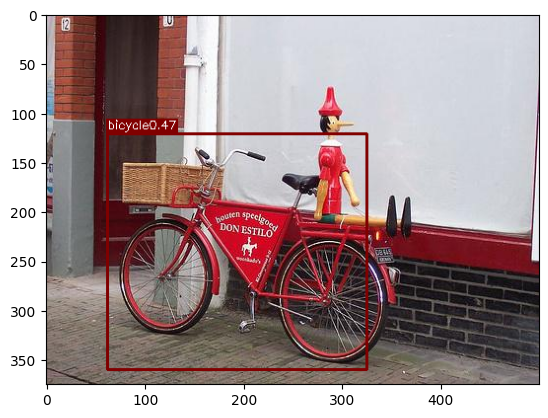

In [6]:
function.visualize(model, './Generate_dataset/images/000015.jpg')

dog0.31


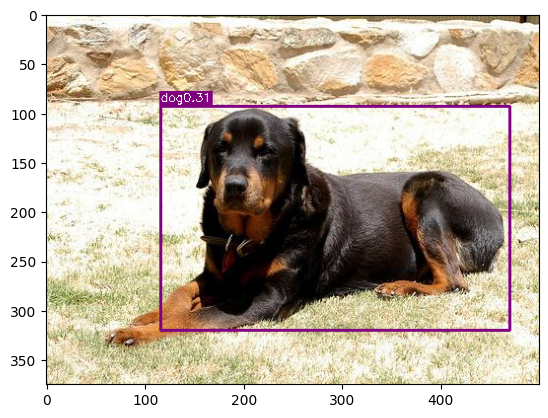

In [7]:
function.visualize(model, './Generate_dataset/images/000037.jpg')

car0.13


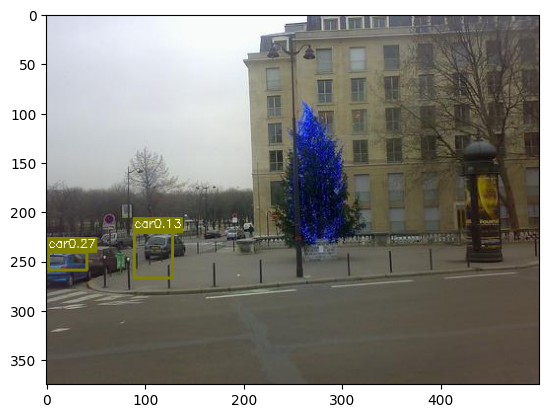

In [8]:
function.visualize(model, './Generate_dataset/images/000103.jpg')

car0.33


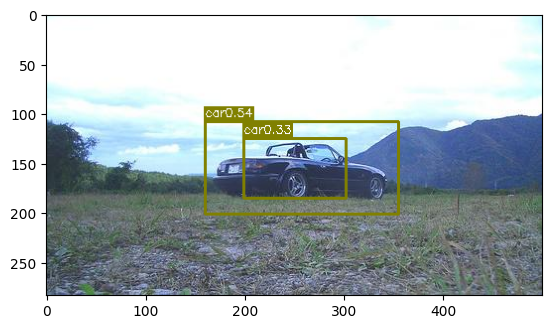

In [9]:
function.visualize(model, './Generate_dataset/images/003055.jpg')

### *References*
[1] https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/
